In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [2]:
class_num = 12
batch_size=32
target_size=(200,200)

gen = ImageDataGenerator(rescale=1/255.)
train_gen = gen.flow_from_directory('./data/train/', target_size=target_size, class_mode='categorical', batch_size=batch_size, shuffle=True)
valid_gen = gen.flow_from_directory('./data/valid/', target_size=target_size, class_mode='categorical', batch_size=batch_size, shuffle=True)
test_gen = gen.flow_from_directory('./data/test/', target_size=target_size, class_mode='categorical', batch_size=batch_size, shuffle=True)

Found 36720 images belonging to 12 classes.
Found 12240 images belonging to 12 classes.
Found 12240 images belonging to 12 classes.


In [3]:
from tensorflow.keras.applications import InceptionResNetV2

InceptionResNetV2_base = InceptionResNetV2(weights='imagenet',
                         include_top=False,        # class 3개로 분류 학습시켜야 해서 레이어 분리시킨 후, Desnse(3) 추가..?
                         input_shape=(200, 200, 3))

InceptionResNetV2_base.summary()

219062272/219055592 [==============================] - 19s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
____________

In [4]:
model = models.Sequential()
model.add(InceptionResNetV2_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(class_num, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 24576)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6291712   
_________________________________________________________________
dense_1 (Dense)              (None, 12)                3084      
Total params: 60,631,532
Trainable params: 60,570,988
Non-trainable params: 60,544
_________________________________________________________________


In [5]:
#저장할 모델명(폴더명)
model_name = 'InceptionResNetV2_12class'

#폴더생성
if 'save_models' not in os.listdir(): os.mkdir('save_models')
if model_name not in os.listdir('save_models'): os.mkdir('./save_models/{}'.format(model_name))
#모델 저장 path
path_checkpoint = "./save_models/{}/".format(model_name) 
#모델 저장 코드(weight만 저장)
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5, restore_best_weights=True)
modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(monitor="val_loss", filepath=path_checkpoint, verbose=1, save_weights_only=False, save_best_only=True, save_format='tf')

#fit
optimizer = tf.keras.optimizers.Adam(lr=0.00001)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = 'accuracy')
history = model.fit(train_gen, validation_data=valid_gen, batch_size=batch_size, epochs=5, callbacks=[es_callback, modelckpt_callback])

Epoch 1/5
1148/1148 [==============================] - ETA: 0s - loss: 0.6921 - accuracy: 0.7923
Epoch 00001: val_loss improved from inf to 0.51180, saving model to ./save_models/InceptionResNetV2_12class/
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./save_models/InceptionResNetV2_12class/assets
1148/1148 [==============================] - 416s 363ms/step - loss: 0.6921 - accuracy: 0.7923 - val_loss: 0.5118 - val_accuracy: 0.8484
Epoch 2/5
1148/1148 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9890
Epoch 00002: val_loss improved from 0.51180 to 0.50544, saving model to ./save_models/InceptionResNetV2_12class/
INFO:tensorflow:Assets written to: ./save_models/InceptionResNetV2_12class/assets
1148/1148 [==============================] - 424s

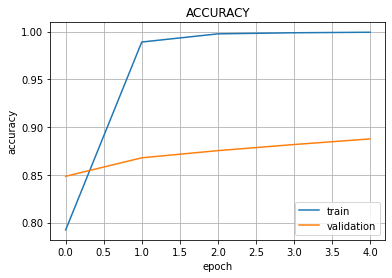

In [6]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ACCURACY')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend(['train','validation'], loc = 'best')

In [7]:
#저장된 최고 성능 모델 불러오기
model_loaded = tf.keras.models.load_model(path_checkpoint)

#test score 확인
score = model_loaded.evaluate(test_gen) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

383/383 [==============================] - 31s 80ms/step - loss: 0.5501 - accuracy: 0.8755
Test loss: 0.55012446641922
Test accuracy: 0.8754901885986328


In [10]:
# 폴더 제거
import shutil
for i in ['Xception']: shutil.rmtree(i)